In [13]:
import os, sys

# go up one level from the notebook dir
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

print("REPO_ROOT:", REPO_ROOT)

import torch
from sklearn import metrics
import numpy as np
import math

from src import losses
from src.models import (
    StandardThreeLayerDNN,
    SNGPThreeLayerDNN,
    RandomFeatureGaussianProcess,
    ResFFN12_128,
    SNGP_ResFFN12_128,
)
from src.utils import (
    train_model,
    create_moons_data_loaders,
    get_data_from_loader,
    apply_bounded_spectral_norm,
    compute_covariance,
)
from src.viz_utils import (
    display_data_splits,
    plot_loss,
    plot_preds,
    plot_probas_over_dense_grid,
    plot_probabilities,
    plot_probabilities_gp,
    plot_thresholded_predictions,
)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

REPO_ROOT: /Users/shanewilliams/GradSchool/Research/sngp-sandbox
Using MPS (Apple Metal)
Final device: mps


# **SNGP TOY EXAMPLE:**

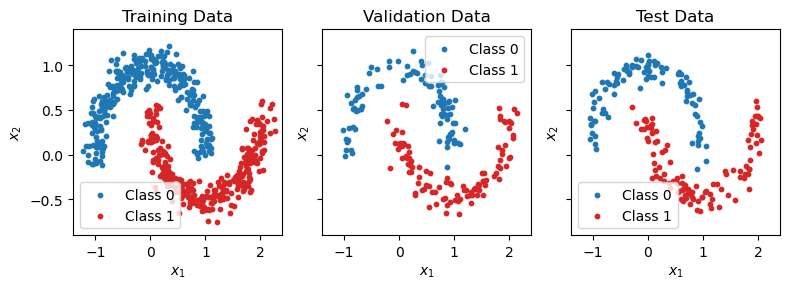

In [14]:
train_loader, val_loader, test_loader = create_moons_data_loaders(1_000, 1_000)
display_data_splits(train_loader, val_loader, test_loader)

In [15]:
input_size = 2
output_size = 2
hidden_size = 64

model = StandardThreeLayerDNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# apply_bounded_spectral_norm(model, name='weight', spec_norm_iteration=15, spec_norm_bound=1.0)
# summary(model, input_size=(1, 2))

model, info = train_model(model, device, train_loader, val_loader, losses, n_epochs=500, lr=0.1, do_early_stopping=True, model_filename="../results/notebook_results/models/vanilla_best_model.pth")

100%|██████████| 501/501 [00:06<00:00, 73.27it/s, tr_xent=0.0227, tr_err=0, va_xent=0.0322, va_err=0.005, batch_done=1]      


Finished after epoch 500, best epoch=500


torch.Size([160000, 2])


/Users/shanewilliams/GradSchool/Research/sngp-sandbox/src/viz_utils.py:531: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


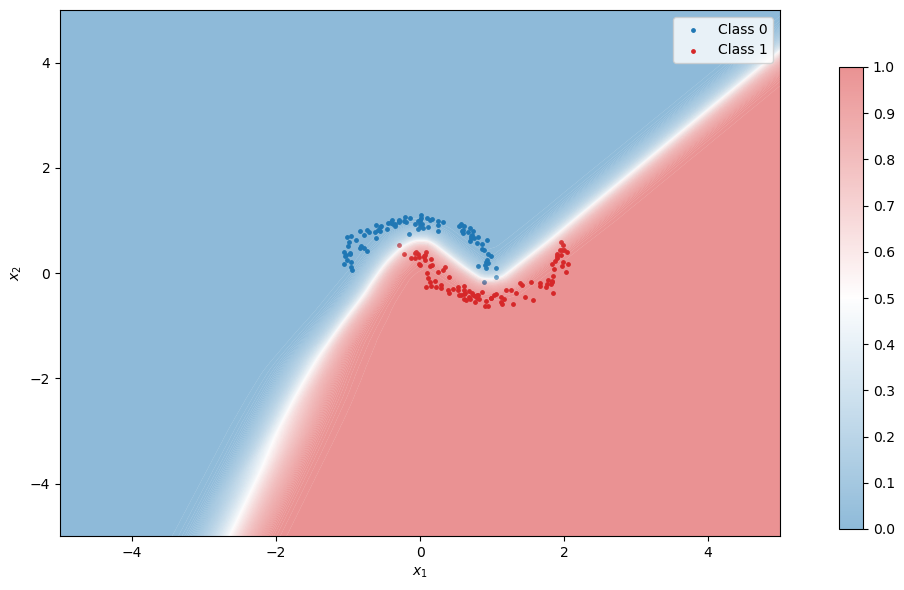

In [16]:
%reload_ext autoreload
plot_probabilities(model, test_loader, device=device, filename="../results/notebook_results/plots/vanilla_dnn_moons_probabilities.png")

In [17]:
%reload_ext autoreload
input_size = 2
output_size = 2
rank = 5_000
lengthscale = 0.1
outputscale = 0.5


sngp_model = RandomFeatureGaussianProcess(in_features=input_size, out_features=output_size, rank=rank, lengthscale=lengthscale, outputscale=outputscale)

100%|██████████| 1001/1001 [00:11<00:00, 88.67it/s, tr_xent=0.0628, tr_err=0, va_xent=0.0835, va_err=0, batch_done=1]


Finished after epoch 1000, best epoch=1000


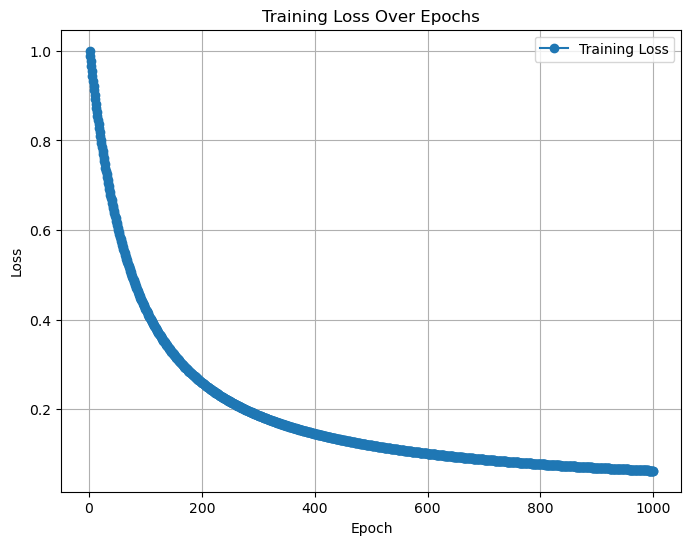

In [18]:
sngp_model, new_info = train_model(sngp_model, device, train_loader, val_loader, losses, n_epochs=1_000, lr=2.0, do_early_stopping=True, model_filename="../results/notebook_results/models/sngp_best_model.pth")
plot_loss(new_info)

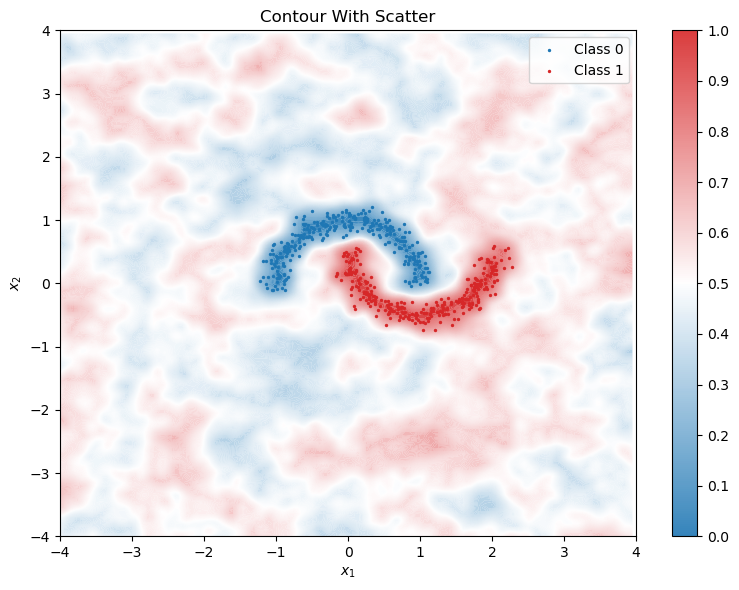

In [19]:
%reload_ext autoreload
plot_probabilities_gp(sngp_model, train_loader, num_samples=10_000, compute_covariance=True, device=device, filename="../results/notebook_results/plots/sngp_moons_probabilities.png")

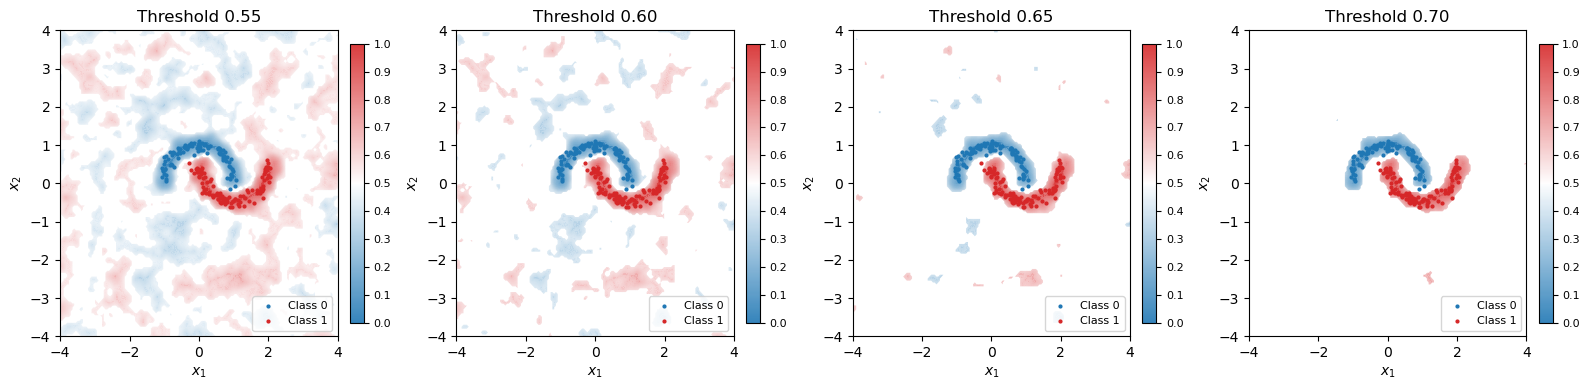

'../results/notebook_results/plots/sngp_moons_thresholded_predictions.png'

In [20]:
%reload_ext autoreload
preds_file = "preds.pt"
plot_thresholded_predictions(preds_file, test_loader, thresholds=[0.55, 0.6, 0.65, 0.7], filename="../results/notebook_results/plots/sngp_moons_thresholded_predictions.png")